In [2082]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates # type: ignore
import matplotlib.ticker as ticker # type: ignore
from matplotlib.axis import Axis # type: ignore
import datetime as dt 

import time
start = time.time()

In [2083]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data
    
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # type: ignore # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)


### conso.csv créé par pi4 node-red onglet Linky
#### création de conso_data 

In [2084]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2185370 entries, 0 to 2185369
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 33.3 MB


# reduce to 1 million events

In [2085]:
conso_data = conso_data.tail(1000000)
conso_data.reset_index(drop=True, inplace=True)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Interval  1000000 non-null  int64  
 1   kWh       1000000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 15.3 MB


### conversion Interval -> kWh

In [2086]:
conso_data['sec']=conso_data['Interval']/1000
conso_data

,Interval,kWh,sec
0,37492,0.10,37.492
1,37217,0.10,37.217
2,37337,0.10,37.337
3,37381,0.10,37.381
4,37327,0.10,37.327
...,...,...,...
999995,29716,0.12,29.716
999996,29622,0.12,29.622
999997,29721,0.12,29.721
999998,29908,0.12,29.908


In [2087]:
conso_data['Wh']=3600000/conso_data['Interval']


### Cumul Total interval

In [2088]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [2089]:
l=len(conso_data)-1
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

25862829314000

### Calcul de la date de base = now - cumul_interval

In [2090]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2024, 7, 9, 11, 41, 45, 498537)

In [2091]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [2092]:
conso_data.iloc[0]


Interval     37492.000000
kWh              0.100000
sec             37.492000
Wh              96.020484
cumul(ms)    37492.000000
Name: 0, dtype: float64

### Recréer les dates à partir des cumuls par impulsion


In [2093]:
base

datetime.datetime(2024, 7, 9, 11, 41, 45, 498537)

## créer les dates

In [2094]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0        2024-07-09 11:42:22.990537
1        2024-07-09 11:43:00.207537
2        2024-07-09 11:43:37.544537
3        2024-07-09 11:44:14.925537
4        2024-07-09 11:44:52.252537
                    ...            
999995   2025-05-04 19:46:55.214537
999996   2025-05-04 19:47:24.836537
999997   2025-05-04 19:47:54.557537
999998   2025-05-04 19:48:24.465537
999999   2025-05-04 19:48:54.812537
Name: dates, Length: 1000000, dtype: datetime64[ns]

### create column 'days' avec format 'dd/mm/yy'


In [2095]:
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,37492,0.10,37.492,96.020484,37492,2024-07-09 11:42:22.990537,09/07/24
1,37217,0.10,37.217,96.729989,74709,2024-07-09 11:43:00.207537,09/07/24
2,37337,0.10,37.337,96.419102,112046,2024-07-09 11:43:37.544537,09/07/24
3,37381,0.10,37.381,96.305610,149427,2024-07-09 11:44:14.925537,09/07/24
4,37327,0.10,37.327,96.444933,186754,2024-07-09 11:44:52.252537,09/07/24
...,...,...,...,...,...,...,...
999995,29716,0.12,29.716,121.146857,25862709716,2025-05-04 19:46:55.214537,04/05/25
999996,29622,0.12,29.622,121.531294,25862739338,2025-05-04 19:47:24.836537,04/05/25
999997,29721,0.12,29.721,121.126476,25862769059,2025-05-04 19:47:54.557537,04/05/25
999998,29908,0.12,29.908,120.369132,25862798967,2025-05-04 19:48:24.465537,04/05/25


### save conso_data with dates

In [2096]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [2097]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
here = now.strftime('%H:%M:%S')
today, date, month, year, here

('04/05/25', 4, 5, 2025, '19:49:10')

In [2098]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [2099]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2820 entries, 997180 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2820 non-null   int64         
 1   kWh        2820 non-null   float64       
 2   sec        2820 non-null   float64       
 3   Wh         2820 non-null   float64       
 4   cumul(ms)  2820 non-null   int64         
 5   dates      2820 non-null   datetime64[ns]
 6   days       2820 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 176.2+ KB


In [2100]:
end = time.time()
print(end - start)

19.40754532814026


### grouped by days

In [2101]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [2102]:
data = list(df_grp['kWh'])
print(data)

[1.882, 3.872, 3.506, 3.827, 3.535, 3.556, 3.765, 3.448, 3.445, 3.275, 3.477, 3.281, 3.722, 3.569, 3.689, 3.592, 3.434, 3.257, 3.18, 2.851, 3.049, 3.624, 3.796, 3.849, 3.003, 3.331, 3.35, 3.502, 3.661, 3.487, 3.665, 3.802, 3.859, 3.667, 4.375, 4.302, 3.895, 3.894, 4.037, 3.801, 3.848, 3.697, 3.293, 3.923, 3.944, 4.445, 3.776, 4.116, 3.794, 3.968, 3.779, 3.962, 3.695, 3.615, 3.5, 3.67, 3.513, 4.136, 3.716, 3.445, 3.548, 3.243, 2.443, 1.795, 1.793, 1.793, 1.796, 2.483, 1.855, 1.787, 1.791, 1.791, 1.82, 1.822, 1.815, 1.817, 1.818, 1.818, 1.816, 1.813, 1.785, 1.786, 1.785, 1.787, 1.782, 1.797, 1.788, 1.79, 1.785, 1.795, 1.803, 1.795, 1.804, 1.795, 1.785, 1.79, 1.785, 1.79, 1.797, 1.791, 1.801, 1.803, 1.795, 1.8, 1.798, 2.796, 3.997, 3.647, 3.922, 3.088, 3.6, 4.003, 3.446, 3.379, 3.958, 3.341, 4.168, 3.082, 4.037, 3.145, 3.357, 3.487, 4.0, 3.295, 3.367, 3.824, 3.226, 3.545, 3.353, 3.866, 3.402, 3.789, 3.288, 4.469, 3.669, 3.82, 3.473, 4.09, 3.488, 3.419, 3.509, 3.668, 3.734, 4.06, 3.544, 3.

In [2103]:
# save to file
# import pickle
# path = r'kwh_mean.pkl'
# with open(path,'wb') as file:
#     pickle.dump(data, file)

In [2104]:
end = time.time()
print(end - start)

20.566890001296997


### plot function by day
#### show('dd/mm/yy')

In [2105]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # type: ignore
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    #print(conso_day)
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


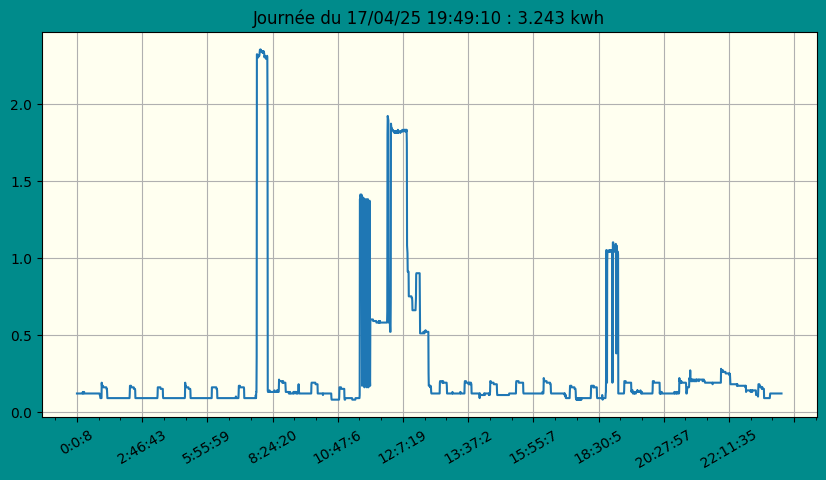

In [2106]:
show('17/04/25')

In [2107]:
end = time.time()
print(end - start)

23.24791646003723


### 1 kWh window in data of one day
#### df = conso_day

In [2108]:
df = conso_day
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
997180,26814,0.13,26.814,134.258223,25791508231,2025-05-04 00:00:13.729537,04/05/25
997181,26212,0.14,26.212,137.341676,25791534443,2025-05-04 00:00:39.941537,04/05/25
997182,25085,0.14,25.085,143.512059,25791559528,2025-05-04 00:01:05.026537,04/05/25
997183,25186,0.14,25.186,142.936552,25791584714,2025-05-04 00:01:30.212537,04/05/25
997184,25738,0.14,25.738,139.871008,25791610452,2025-05-04 00:01:55.950537,04/05/25
...,...,...,...,...,...,...,...
999995,29716,0.12,29.716,121.146857,25862709716,2025-05-04 19:46:55.214537,04/05/25
999996,29622,0.12,29.622,121.531294,25862739338,2025-05-04 19:47:24.836537,04/05/25
999997,29721,0.12,29.721,121.126476,25862769059,2025-05-04 19:47:54.557537,04/05/25
999998,29908,0.12,29.908,120.369132,25862798967,2025-05-04 19:48:24.465537,04/05/25


In [2109]:

def period(df=df, p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


In [2110]:
df = conso_day
len(df)

2820

In [2111]:
period()  # first kWh
if len(df)>1000:
    period(p=2) # second period

2025-05-04 00:00:13.729537	2025-05-04 08:26:27.163537	8h 26m 13s 	1000
2025-05-04 08:26:27.163537	2025-05-04 13:39:06.072537	5h 12m 38s 	2000


In [2112]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.299509
dtype: float64

In [2113]:
end = time.time()
print(end - start)

23.59004807472229


## mean for data grouped by days

In [2114]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.333333
dtype: float64

In [2115]:
last=df_grp.iloc[-1]['kWh']
last

np.float64(2.82)

# conso by date


In [2116]:
# select day
day = today

#day = '16/08/24'
day

'04/05/25'

In [2117]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
997180,26814,0.13,26.814,134.258223,25791508231,2025-05-04 00:00:13.729537,04/05/25
997181,26212,0.14,26.212,137.341676,25791534443,2025-05-04 00:00:39.941537,04/05/25
997182,25085,0.14,25.085,143.512059,25791559528,2025-05-04 00:01:05.026537,04/05/25
997183,25186,0.14,25.186,142.936552,25791584714,2025-05-04 00:01:30.212537,04/05/25
997184,25738,0.14,25.738,139.871008,25791610452,2025-05-04 00:01:55.950537,04/05/25
...,...,...,...,...,...,...,...
999995,29716,0.12,29.716,121.146857,25862709716,2025-05-04 19:46:55.214537,04/05/25
999996,29622,0.12,29.622,121.531294,25862739338,2025-05-04 19:47:24.836537,04/05/25
999997,29721,0.12,29.721,121.126476,25862769059,2025-05-04 19:47:54.557537,04/05/25
999998,29908,0.12,29.908,120.369132,25862798967,2025-05-04 19:48:24.465537,04/05/25


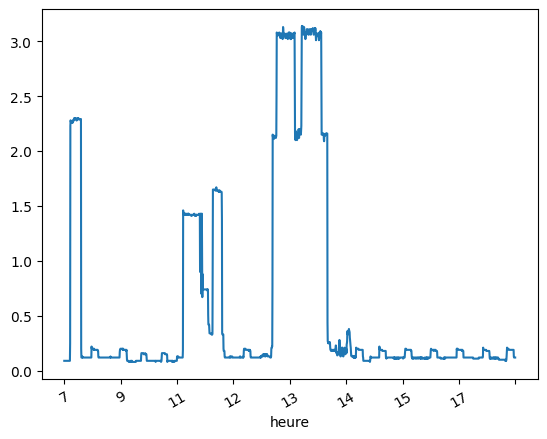

In [2118]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)) #+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df3= conso_day.set_index('heure')
df3.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [2119]:
end = time.time()
print(end - start)

24.54680037498474


### grouped by 'heure'

In [2120]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2820 entries, 997180 to 999999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2820 non-null   int64         
 1   kWh        2820 non-null   float64       
 2   sec        2820 non-null   float64       
 3   Wh         2820 non-null   float64       
 4   cumul(ms)  2820 non-null   int64         
 5   dates      2820 non-null   datetime64[ns]
 6   days       2820 non-null   object        
 7   heure      2820 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 198.3+ KB


In [2121]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
997180,26814,0.13,26.814,134.258223,25791508231,2025-05-04 00:00:13.729537,04/05/25
997181,26212,0.14,26.212,137.341676,25791534443,2025-05-04 00:00:39.941537,04/05/25
997182,25085,0.14,25.085,143.512059,25791559528,2025-05-04 00:01:05.026537,04/05/25
997183,25186,0.14,25.186,142.936552,25791584714,2025-05-04 00:01:30.212537,04/05/25
997184,25738,0.14,25.738,139.871008,25791610452,2025-05-04 00:01:55.950537,04/05/25
...,...,...,...,...,...,...,...
999995,29716,0.12,29.716,121.146857,25862709716,2025-05-04 19:46:55.214537,04/05/25
999996,29622,0.12,29.622,121.531294,25862739338,2025-05-04 19:47:24.836537,04/05/25
999997,29721,0.12,29.721,121.126476,25862769059,2025-05-04 19:47:54.557537,04/05/25
999998,29908,0.12,29.908,120.369132,25862798967,2025-05-04 19:48:24.465537,04/05/25


In [2122]:
# group by hour, df  = data of a chosen day
df_byhour = df3[['days','kWh']].groupby('heure', sort=False)
df_byhour.groups

{'0': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', ...], '1': ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '

In [2123]:
kwh_byhour = df_byhour['kWh']
kwh_byhour.count()

heure
0     141
1     131
2     107
3     100
4     101
5      99
6     100
7     156
8     133
9     109
10    101
11    262
12    134
13    388
14    136
15    128
16    133
17    133
18    127
19    101
Name: kWh, dtype: int64

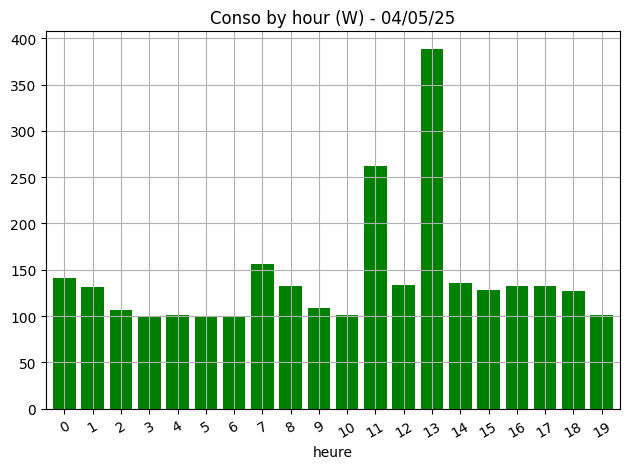

In [2124]:
kwh_byhour.count().plot(grid=True, kind='bar',color='green',width=.8)
plt.title(f'Conso by hour (W) - {day}')
plt.xticks(rotation=30);
plt.tight_layout()

In [2125]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 09/07/24 to 04/05/25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     300 non-null    float64
dtypes: float64(1)
memory usage: 4.7+ KB


In [2126]:
# give the periods of 1 kwh in a day
period()

2025-05-04 00:00:13.729537	2025-05-04 08:26:27.163537	8h 26m 13s 	1000


In [2127]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
    df.iloc[0].dates, df.iloc[1000].dates
#df.dates.dt.time


In [2128]:

# save data
# df_grp.to_csv('df_grp.csv')
# df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp


In [2129]:
df_grp.mean()


kWh    3.333333
dtype: float64

In [2130]:
df_grp.head()


,kWh
days,
09/07/24,1.882
10/07/24,3.872
11/07/24,3.506
12/07/24,3.827
13/07/24,3.535


In [2131]:
df_grp.tail()


,kWh
days,
30/04/25,2.872
01/05/25,2.639
02/05/25,3.566
03/05/25,3.703
04/05/25,2.820


In [2132]:
end = time.time()
print(end - start)

26.005706071853638


# plot les 100 derniers jours


In [2133]:
# moyenne sur 100 jours
df_grp.tail(100).mean()


kWh    3.50426
dtype: float64

Text(0.5, 1.0, 'Conso (kWh) last 100 days')

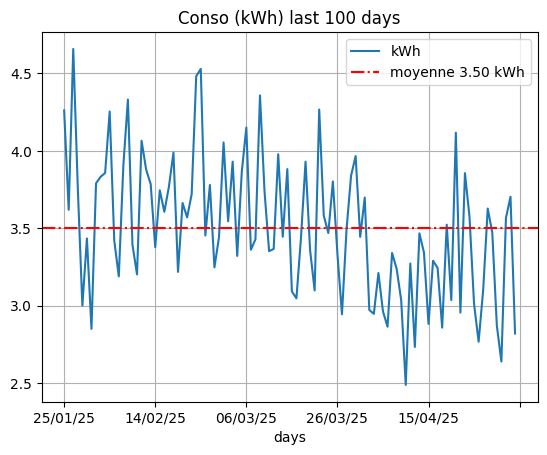

In [2134]:
# plot last 100 days
df_100 = df_grp.tail(100)
df_100.plot()
plt.axhline(y=np.nanmean(df_100),c='red', ls='-.',label=f'moyenne {np.nanmean(df_100):.2f} kWh')
plt.grid()
plt.legend()
plt.title('Conso (kWh) last 100 days')


In [2135]:
# max min during last 100 days
df_100.describe().loc[['min','max']]


,kWh
min,2.488
max,4.658


In [2136]:
end = time.time()
print(end - start)

26.933369159698486


In [2137]:
df_grp[-31:-1].index[0],df_grp[-31:-1].index[-5]

('04/04/25', '29/04/25')

In [2138]:
moyenne = df_grp.iloc[-31:-1].mean()
moyenne

kWh    3.201533
dtype: float64

Text(0.5, 1.0, 'Last month conso by day')

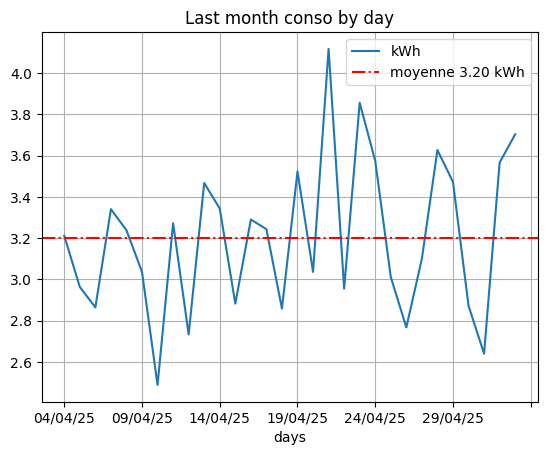

In [2139]:
# plot last monthh
df_grp.iloc[-31:-1].plot()
plt.axhline(y=np.nanmean(df_grp.iloc[-31:-1]),c='red', ls='-.',label=f'moyenne {np.nanmean(df_grp.iloc[-31:-1]):.2f} kWh')  
plt.legend()
plt.grid()
plt.title('Last month conso by day')


In [2140]:
month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))

Max : 21/04/25 4.117
Min : 10/04/25 2.488


# Temps de conso par tranche de 1 kWh

In [2141]:
def show_tranches():    # temps de conso par tranches de 1kwh
    tranches = len(df)//1000
    print(tranches+1)
    for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
        if len(df)>(p-1)*1000:
            period(p=p)

show_tranches()


3
2025-05-04 00:00:13.729537	2025-05-04 08:26:27.163537	8h 26m 13s 	1000
2025-05-04 08:26:27.163537	2025-05-04 13:39:06.072537	5h 12m 38s 	2000
2025-05-04 13:39:06.072537	2025-05-04 19:48:54.812537	6h 9m 48s 	820


In [2142]:
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour


('19:49:10', 2.82, 2820)

In [2143]:
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2820 entries, 997180 to 999999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2820 non-null   int64         
 1   kWh        2820 non-null   float64       
 2   sec        2820 non-null   float64       
 3   Wh         2820 non-null   float64       
 4   cumul(ms)  2820 non-null   int64         
 5   dates      2820 non-null   datetime64[ns]
 6   days       2820 non-null   object        
 7   heure      2820 non-null   object        
 8   hours      2820 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 220.3+ KB


In [2144]:
conso_hours['heure'], conso_hours['hours']

(997180     0
 997181     0
 997182     0
 997183     0
 997184     0
           ..
 999995    19
 999996    19
 999997    19
 999998    19
 999999    19
 Name: heure, Length: 2820, dtype: object,
 997180    00
 997181    00
 997182    00
 997183    00
 997184    00
           ..
 999995    19
 999996    19
 999997    19
 999998    19
 999999    19
 Name: hours, Length: 2820, dtype: object)

In [2145]:
end = time.time()
print(end - start)

28.005022287368774


# select number of days to display


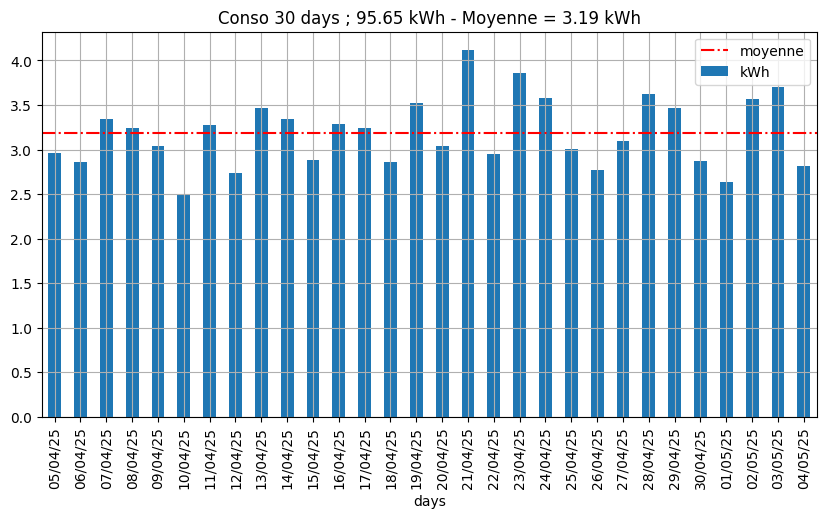

In [2146]:
span = 30
conso_mois = round(df_grp.tail(span)['kWh'].sum(),2)

# Plot the figure without labels
moy = round(np.nanmean(df_grp.tail(span)),2)
#conso_mois = sum(df_grp.tail(span)['kWh'])
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight')
 
plt.title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
plt.xticks(rotation=90);


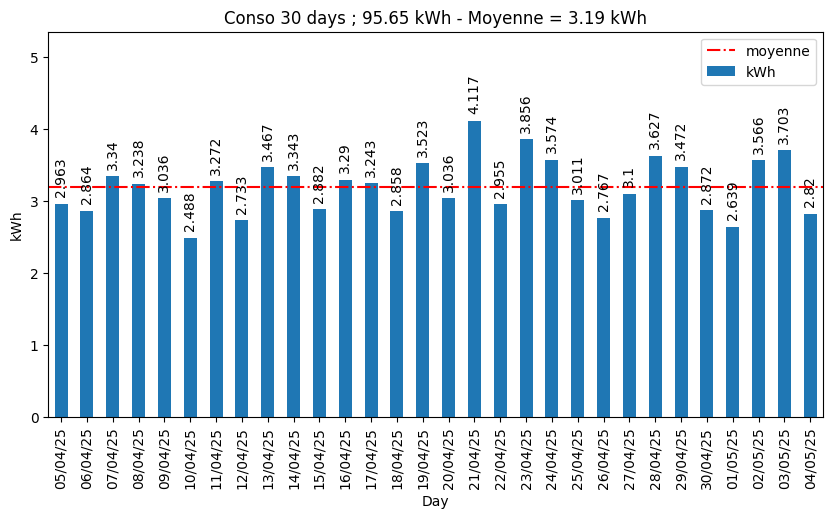

In [2147]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
#ax.set_title(f"Conso by {span} days")
ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [2148]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
05/04/25    2.963
06/04/25    2.864
07/04/25    3.340
08/04/25    3.238
09/04/25    3.036
10/04/25    2.488
11/04/25    3.272
12/04/25    2.733
13/04/25    3.467
14/04/25    3.343
15/04/25    2.882
16/04/25    3.290
17/04/25    3.243
18/04/25    2.858
19/04/25    3.523
20/04/25    3.036
21/04/25    4.117
22/04/25    2.955
23/04/25    3.856
24/04/25    3.574
25/04/25    3.011
26/04/25    2.767
27/04/25    3.100
28/04/25    3.627
29/04/25    3.472
30/04/25    2.872
01/05/25    2.639
02/05/25    3.566
03/05/25    3.703
04/05/25    2.820
Name: kWh, dtype: float64

In [2149]:
x_labels=df_grp.tail(span).index
x_labels

Index(['05/04/25', '06/04/25', '07/04/25', '08/04/25', '09/04/25', '10/04/25',
       '11/04/25', '12/04/25', '13/04/25', '14/04/25', '15/04/25', '16/04/25',
       '17/04/25', '18/04/25', '19/04/25', '20/04/25', '21/04/25', '22/04/25',
       '23/04/25', '24/04/25', '25/04/25', '26/04/25', '27/04/25', '28/04/25',
       '29/04/25', '30/04/25', '01/05/25', '02/05/25', '03/05/25', '04/05/25'],
      dtype='object', name='days')

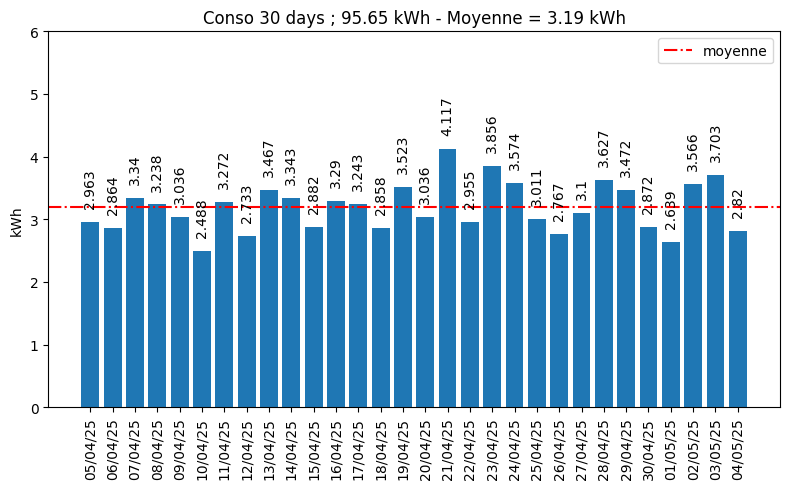

In [2150]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
#ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
ax.set(ylabel='kWh', title=f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh', ylim=(0, 6))
plt.xticks(rotation=90);


In [2151]:
end = time.time()
print(end - start)

32.9392831325531


In [2152]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

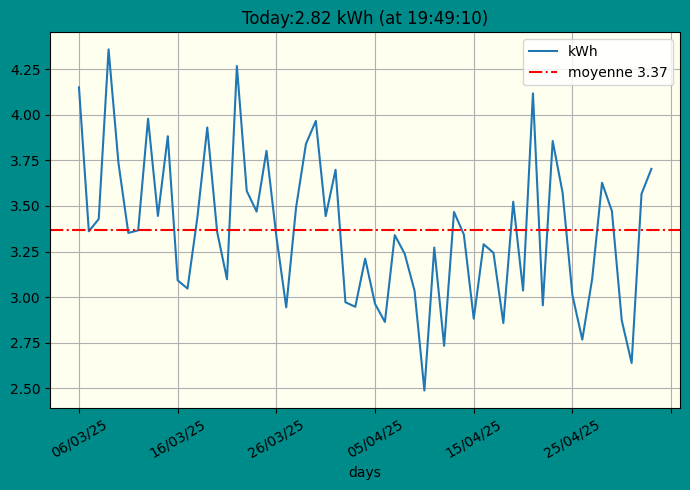

In [2153]:
# 2 last months
scan = 60
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")

moy = round(np.nanmean(df_grp.iloc[-scan:-1]),2)
df_grp.iloc[-scan:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(f'Today:{last} kWh (at {here})')
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

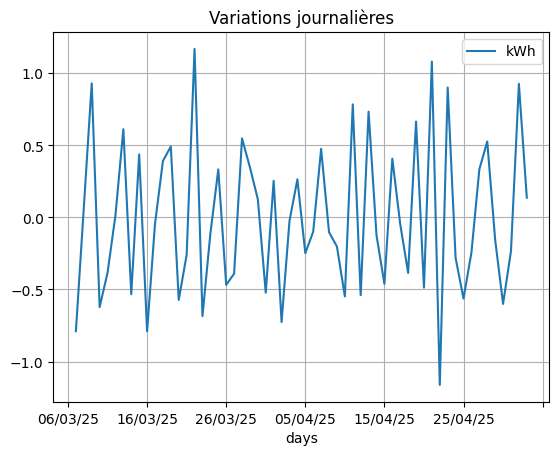

In [2154]:
# variations journalières sur 60 jours
df_grp.iloc[-60:-1].diff().plot(grid=True)
plt.title('Variations journalières')

In [2155]:
end = time.time()
print(end - start)

34.33573913574219


# Data from 21/08/23

In [2156]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')

conso_days['months']= conso_days['dates'].dt.strftime('%Y-%m')
conso_days['day']= conso_days['dates'].dt.strftime('%d')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,37492,0.10,37.492,96.020484,37492,2024-07-09 11:42:22.990537,09/07/24,11,2024-07,09
1,37217,0.10,37.217,96.729989,74709,2024-07-09 11:43:00.207537,09/07/24,11,2024-07,09
2,37337,0.10,37.337,96.419102,112046,2024-07-09 11:43:37.544537,09/07/24,11,2024-07,09
3,37381,0.10,37.381,96.305610,149427,2024-07-09 11:44:14.925537,09/07/24,11,2024-07,09
4,37327,0.10,37.327,96.444933,186754,2024-07-09 11:44:52.252537,09/07/24,11,2024-07,09
...,...,...,...,...,...,...,...,...,...,...
999995,29716,0.12,29.716,121.146857,25862709716,2025-05-04 19:46:55.214537,04/05/25,19,2025-05,04
999996,29622,0.12,29.622,121.531294,25862739338,2025-05-04 19:47:24.836537,04/05/25,19,2025-05,04
999997,29721,0.12,29.721,121.126476,25862769059,2025-05-04 19:47:54.557537,04/05/25,19,2025-05,04
999998,29908,0.12,29.908,120.369132,25862798967,2025-05-04 19:48:24.465537,04/05/25,19,2025-05,04


In [2157]:
end = time.time()
print(end - start)

76.05592179298401


In [2158]:
conso_grouped_by_month = conso_days[['day','hours','months','kWh']].groupby('months', sort=False)

conso_grouped_by_month.groups.keys()

dict_keys(['2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04', '2025-05'])

# define month to show

Text(0.5, 1.0, 'Conso by day (W) (2025-04)')

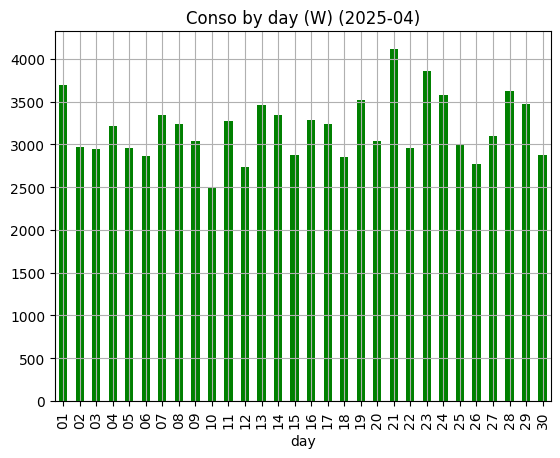

In [2159]:
m = '2025-04'
month=conso_grouped_by_month.get_group(m)
conso_grouped_by_month_day = month.groupby(['day'], sort=False)
conso_grouped_by_month_day['kWh'].count().plot(grid=True,kind='bar',color='green',width=.5)
plt.title(f'Conso by day (W) ({m})')

In [2160]:
c=conso_grouped_by_month_day['hours'].count()
c.mean()


np.float64(3191.8333333333335)

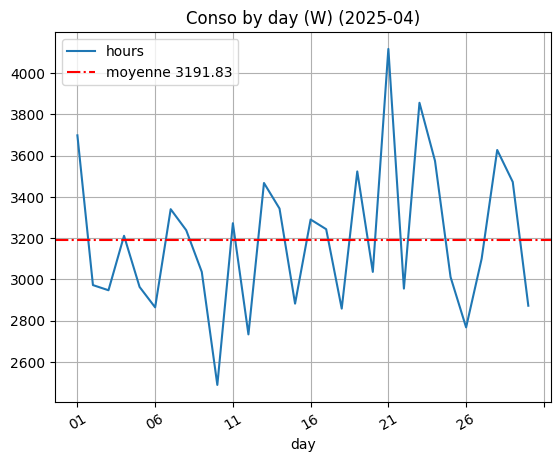

In [2161]:
conso_grouped_by_month_day['hours'].count().plot(grid=True)#, kind='bar', color='green', width=.8)
moy = round(c.mean(),2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (W) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);


In [2162]:
conso_grouped_by_month_and_day = conso_days[['day','hours','months','kWh']].groupby(['months','day'], sort=False)

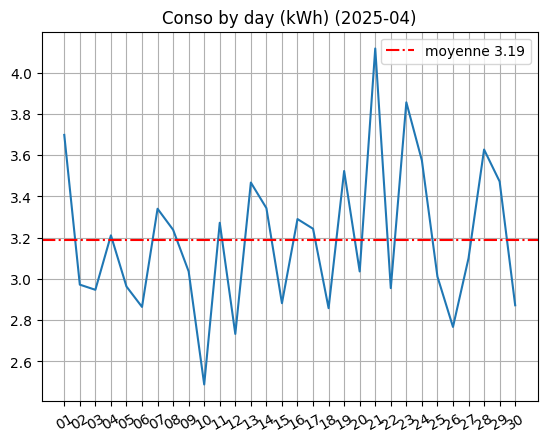

In [2163]:
plt.plot(conso_grouped_by_month_day['kWh'].count()/1000)
plt.grid()
moy = round(c.mean()/1000,2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (kWh) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);

In [2164]:
# Example: Get data for January 2025 at hour '00'
#group = conso_grouped_by_month_and_day.get_group('2025-01')
#group

In [2165]:
# group.plot(grid=True, kind='bar', color='green', width=.8)
# plt.title('Conso by hour (W) - 2025-01')
# plt.xticks(rotation=30);


In [2166]:
# conso total par mois
conso_grouped_by_month.count()


,day,hours,kWh
months,,,
2024-07,78632,78632,78632
2024-08,117335,117335,117335
2024-09,69780,69780,69780
2024-10,73505,73505,73505
2024-11,108515,108515,108515
2024-12,113756,113756,113756
2025-01,113631,113631,113631
2025-02,104491,104491,104491
2025-03,111872,111872,111872


In [2167]:
# example groupby with apply
df2 = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df2.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [2168]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [2169]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
09/07/24,1882
10/07/24,3872
11/07/24,3506
12/07/24,3827
13/07/24,3535
...,...
30/04/25,2872
01/05/25,2639
02/05/25,3566


In [2170]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,37492,0.10,37.492,96.020484,37492,2024-07-09 11:42:22.990537,09/07/24,11,2024-07,09
1,37217,0.10,37.217,96.729989,74709,2024-07-09 11:43:00.207537,09/07/24,11,2024-07,09
2,37337,0.10,37.337,96.419102,112046,2024-07-09 11:43:37.544537,09/07/24,11,2024-07,09
3,37381,0.10,37.381,96.305610,149427,2024-07-09 11:44:14.925537,09/07/24,11,2024-07,09
4,37327,0.10,37.327,96.444933,186754,2024-07-09 11:44:52.252537,09/07/24,11,2024-07,09
...,...,...,...,...,...,...,...,...,...,...
999995,29716,0.12,29.716,121.146857,25862709716,2025-05-04 19:46:55.214537,04/05/25,19,2025-05,04
999996,29622,0.12,29.622,121.531294,25862739338,2025-05-04 19:47:24.836537,04/05/25,19,2025-05,04
999997,29721,0.12,29.721,121.126476,25862769059,2025-05-04 19:47:54.557537,04/05/25,19,2025-05,04
999998,29908,0.12,29.908,120.369132,25862798967,2025-05-04 19:48:24.465537,04/05/25,19,2025-05,04


In [2171]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                             
09/07/24 11    0       09/07/24    11  0.10
               1       09/07/24    11  0.10
               2       09/07/24    11  0.10
               3       09/07/24    11  0.10
               4       09/07/24    11  0.10
...                         ...   ...   ...
04/05/25 19    999995  04/05/25    19  0.12
               999996  04/05/25    19  0.12
               999997  04/05/25    19  0.12
               999998  04/05/25    19  0.12
               999999  04/05/25    19  0.12

[1000000 rows x 3 columns]

In [2172]:
groupallbyday.indices.keys()

dict_keys(['09/07/24', '10/07/24', '11/07/24', '12/07/24', '13/07/24', '14/07/24', '15/07/24', '16/07/24', '17/07/24', '18/07/24', '19/07/24', '20/07/24', '21/07/24', '22/07/24', '23/07/24', '24/07/24', '25/07/24', '26/07/24', '27/07/24', '28/07/24', '29/07/24', '30/07/24', '31/07/24', '01/08/24', '02/08/24', '03/08/24', '04/08/24', '05/08/24', '06/08/24', '07/08/24', '08/08/24', '09/08/24', '10/08/24', '11/08/24', '12/08/24', '13/08/24', '14/08/24', '15/08/24', '16/08/24', '17/08/24', '18/08/24', '19/08/24', '20/08/24', '21/08/24', '22/08/24', '23/08/24', '24/08/24', '25/08/24', '26/08/24', '27/08/24', '28/08/24', '29/08/24', '30/08/24', '31/08/24', '01/09/24', '02/09/24', '03/09/24', '04/09/24', '05/09/24', '06/09/24', '07/09/24', '08/09/24', '09/09/24', '10/09/24', '11/09/24', '12/09/24', '13/09/24', '14/09/24', '15/09/24', '16/09/24', '17/09/24', '18/09/24', '19/09/24', '20/09/24', '21/09/24', '22/09/24', '23/09/24', '24/09/24', '25/09/24', '26/09/24', '27/09/24', '28/09/24', '29/0

In [2173]:
groupallbydayhours.indices.keys()

dict_keys([('09/07/24', '11'), ('09/07/24', '12'), ('09/07/24', '13'), ('09/07/24', '14'), ('09/07/24', '15'), ('09/07/24', '16'), ('09/07/24', '17'), ('09/07/24', '18'), ('09/07/24', '19'), ('09/07/24', '20'), ('09/07/24', '21'), ('09/07/24', '22'), ('09/07/24', '23'), ('10/07/24', '11'), ('10/07/24', '12'), ('10/07/24', '13'), ('10/07/24', '14'), ('10/07/24', '15'), ('10/07/24', '16'), ('10/07/24', '17'), ('10/07/24', '18'), ('10/07/24', '19'), ('10/07/24', '20'), ('10/07/24', '21'), ('10/07/24', '22'), ('10/07/24', '23'), ('10/07/24', '00'), ('10/07/24', '01'), ('10/07/24', '02'), ('10/07/24', '03'), ('10/07/24', '04'), ('10/07/24', '05'), ('10/07/24', '06'), ('10/07/24', '07'), ('10/07/24', '08'), ('10/07/24', '09'), ('10/07/24', '10'), ('11/07/24', '11'), ('11/07/24', '12'), ('11/07/24', '13'), ('11/07/24', '14'), ('11/07/24', '15'), ('11/07/24', '16'), ('11/07/24', '17'), ('11/07/24', '18'), ('11/07/24', '19'), ('11/07/24', '20'), ('11/07/24', '21'), ('11/07/24', '22'), ('11/07/2

In [2174]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
09/07/24,1882,1882
10/07/24,3872,3872
11/07/24,3506,3506
12/07/24,3827,3827
13/07/24,3535,3535
...,...,...
30/04/25,2872,2872
01/05/25,2639,2639
02/05/25,3566,3566


In [2175]:
grp_by_day['kWh'].cumsum()

days
09/07/24       1882
10/07/24       5754
11/07/24       9260
12/07/24      13087
13/07/24      16622
             ...   
30/04/25     987272
01/05/25     989911
02/05/25     993477
03/05/25     997180
04/05/25    1000000
Name: kWh, Length: 300, dtype: int64

In [2176]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
09/07/24 11      29
         12     113
         13     114
         14     170
         15     155
...             ...
04/05/25 15     128
         16     133
         17     133
         18     127
         19     101

[7185 rows x 1 columns]

In [2177]:
grp_by_dayhours['kWh'].cumsum()

days      hours
09/07/24  11            29
          12           142
          13           256
          14           426
          15           581
                    ...   
04/05/25  15        999506
          16        999639
          17        999772
          18        999899
          19       1000000
Name: kWh, Length: 7185, dtype: int64

In [2178]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum  diff
days     hours                   
09/07/24 11      29      29   NaN
         12     113     142  84.0
         13     114     256   1.0
         14     170     426  56.0
         15     155     581 -15.0
...             ...     ...   ...
04/05/25 15     128    2326  -8.0
         16     133    2459   5.0
         17     133    2592   0.0
         18     127    2719  -6.0
         19     101    2820 -26.0

[7185 rows x 3 columns]

In [2179]:
today, grp_by_dayhours.loc[today]

('04/05/25',
        kWh  cumsum   diff
 hours                    
 00     141     141    NaN
 01     131     272  -10.0
 02     107     379  -24.0
 03     100     479   -7.0
 04     101     580    1.0
 05      99     679   -2.0
 06     100     779    1.0
 07     156     935   56.0
 08     133    1068  -23.0
 09     109    1177  -24.0
 10     101    1278   -8.0
 11     262    1540  161.0
 12     134    1674 -128.0
 13     388    2062  254.0
 14     136    2198 -252.0
 15     128    2326   -8.0
 16     133    2459    5.0
 17     133    2592    0.0
 18     127    2719   -6.0
 19     101    2820  -26.0)

Text(0.5, 1.0, 'Cumul journalier')

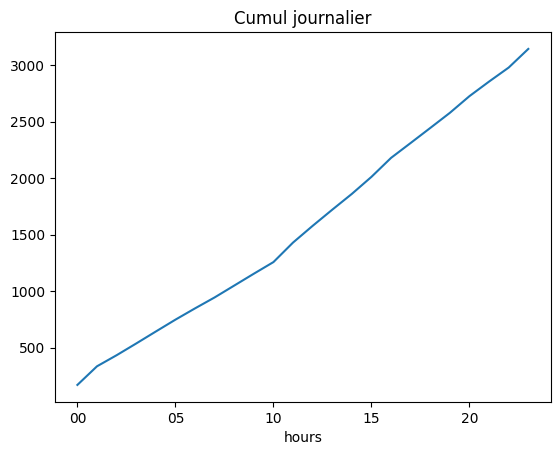

In [2180]:
# progression sans surprise
grp_by_dayhours.loc['05/11/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

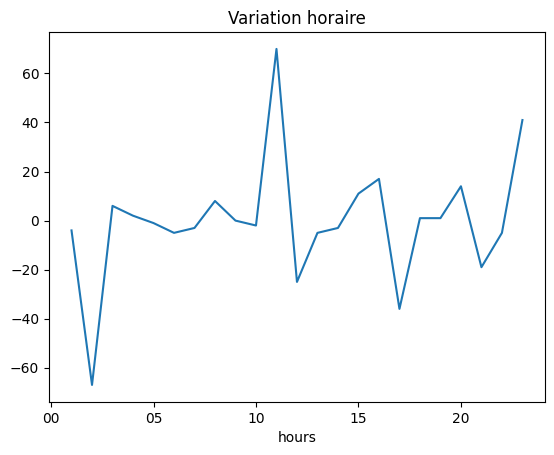

In [2181]:
# plus parlant
grp_by_dayhours.loc['05/11/24']['diff'].plot()
plt.title(r'Variation horaire')

In [2182]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

300

In [2183]:
df_grp.tail(n)['kWh'].describe()


count    300.000000
mean       3.333333
std        0.730571
min        1.782000
25%        3.151750
50%        3.475000
75%        3.794500
max        4.804000
Name: kWh, dtype: float64

In [2184]:
maxday = df_grp.tail(n)['kWh'].idxmax()

In [2185]:
n, np.nanmean(df_grp.tail(n))

(300, np.float64(3.3333333333333335))

Text(0.5, 1.0, '300 days')

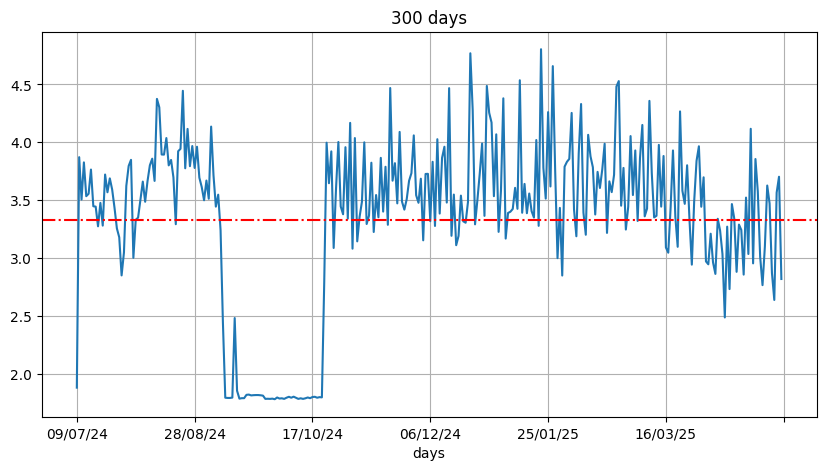

In [2186]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

Text(0.5, 1.0, '100 days')

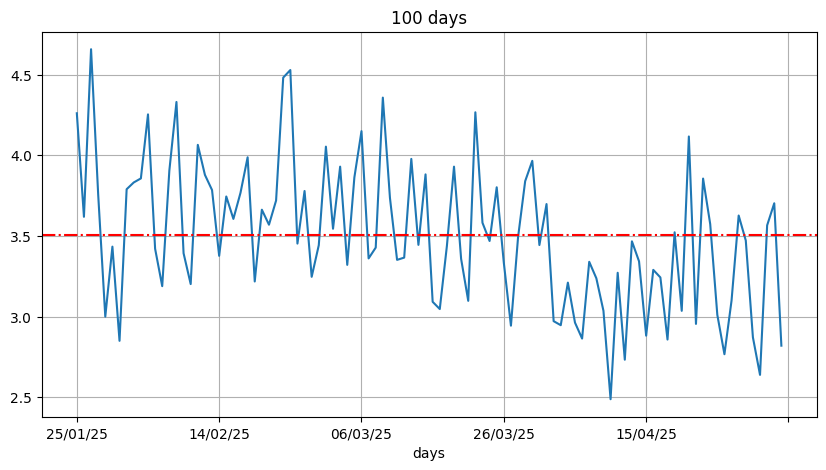

In [2187]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

In [2188]:
np.nanmean(df_grp.tail(span))

np.float64(3.5042599999999995)

In [2189]:
df_grp['kWh']

days
09/07/24    1.882
10/07/24    3.872
11/07/24    3.506
12/07/24    3.827
13/07/24    3.535
            ...  
30/04/25    2.872
01/05/25    2.639
02/05/25    3.566
03/05/25    3.703
04/05/25    2.820
Name: kWh, Length: 300, dtype: float64

In [2190]:
df_grp.describe()

,kWh
count,300.000000
mean,3.333333
std,0.730571
min,1.782000
25%,3.151750
50%,3.475000
75%,3.794500
max,4.804000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

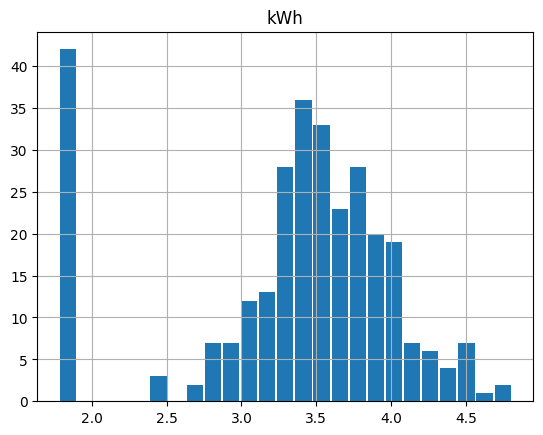

In [2191]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [2192]:
df_grp.tail(span)['kWh']

days
25/01/25    4.261
26/01/25    3.619
27/01/25    4.658
28/01/25    3.758
29/01/25    3.000
            ...  
30/04/25    2.872
01/05/25    2.639
02/05/25    3.566
03/05/25    3.703
04/05/25    2.820
Name: kWh, Length: 100, dtype: float64

# Conso par heure

In [2193]:
day

'04/05/25'

In [2194]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,141,141,NaN
01,131,272,-10.0
02,107,379,-24.0
03,100,479,-7.0
04,101,580,1.0
05,99,679,-2.0
06,100,779,1.0
07,156,935,56.0
08,133,1068,-23.0


In [2195]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


20

In [2196]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 21)

In [2197]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [2198]:
grp_by_dayhours.loc[day,'days'].values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20.])

In [2199]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
14    15.0
15    16.0
16    17.0
17    18.0
18    19.0
19    20.0
Name: days, dtype: float64

In [2200]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [2201]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 20 entries, 00 to 19
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     20 non-null     int64  
 1   cumsum  20 non-null     int64  
 2   diff    19 non-null     float64
 3   days    20 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 800.0+ bytes


In [2202]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
14    15.0
15    16.0
16    17.0
17    18.0
18    19.0
19    20.0
Name: days, dtype: float64

In [2203]:
day

'04/05/25'

In [2204]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,141,141,NaN,1.0
01,131,272,-10.0,2.0
02,107,379,-24.0,3.0
03,100,479,-7.0,4.0
04,101,580,1.0,5.0
05,99,679,-2.0,6.0
06,100,779,1.0,7.0
07,156,935,56.0,8.0
08,133,1068,-23.0,9.0


In [2205]:
kwh = grp_by_dayhours.loc[day][['kWh']]
np.sum(kwh)[0]


c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\jeand\AppData\Local\Temp\ipykernel_17956\3891495459.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.sum(kwh)[0]


np.int64(2820)

c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Text(0.5, 1.0, '04/05/25: kWh    2820\ndtype: int64')

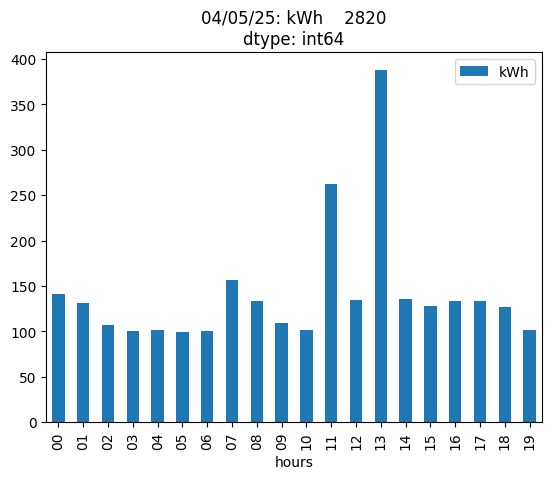

In [2206]:
kwh.plot.bar()
plt.title(f'{day}: {np.sum(kwh)}')

In [2207]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19'],
      dtype='object', name='hours')

# Conso du jour


In [2208]:

grp_by_dayhours.count()

kWh       7185
cumsum    7185
diff      6885
days        20
dtype: int64

'22/01/25'

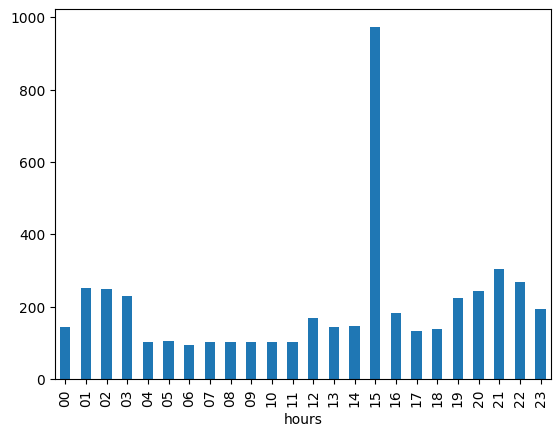

In [2209]:
#day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh.plot(kind='bar')
maxday

In [2210]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

In [2211]:
df_grp.tail(7)['kWh']

days
28/04/25    3.627
29/04/25    3.472
30/04/25    2.872
01/05/25    2.639
02/05/25    3.566
03/05/25    3.703
04/05/25    2.820
Name: kWh, dtype: float64

Total= 350.426 , Moyenne= 3.5042599999999995


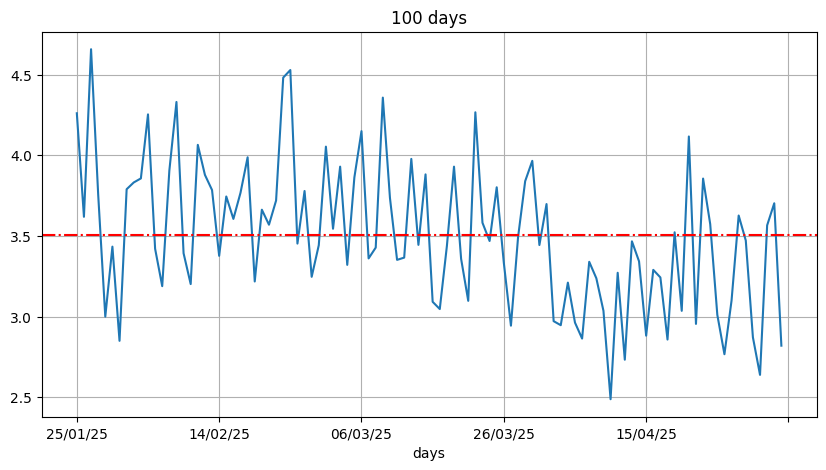

In [2212]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

print('Total=',sum(df_grp.tail(span)['kWh']),', Moyenne=',np.nanmean(df_grp.tail(span)))

In [2213]:
from datetime import datetime

# Get the current time
current_time = datetime.now()

# Convert the time to minutes in a day
minutes_in_day = current_time.hour * 60 + current_time.minute
print(f"Current time: {current_time.strftime('%H:%M:%S')}, Minutes in day: {minutes_in_day}")

Current time: 19:50:31, Minutes in day: 1190


In [2214]:
def convert_to_min_sec(seconds):
    """
    Convert a float value in seconds to minutes and seconds.
    """
    minutes, sec = divmod(seconds, 60)
    return f'{int(minutes)}:{round(sec, 2)}'


In [2215]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(convert_to_min_sec(end - start))

1:39.65


In [2216]:
end - start

99.65027737617493

In [2217]:
#df = conso_day
show_tranches()

3
2025-05-04 00:00:13.729537	2025-05-04 08:26:27.163537	8h 26m 13s 	1000
2025-05-04 08:26:27.163537	2025-05-04 13:39:06.072537	5h 12m 38s 	2000
2025-05-04 13:39:06.072537	2025-05-04 19:48:54.812537	6h 9m 48s 	820


# Today

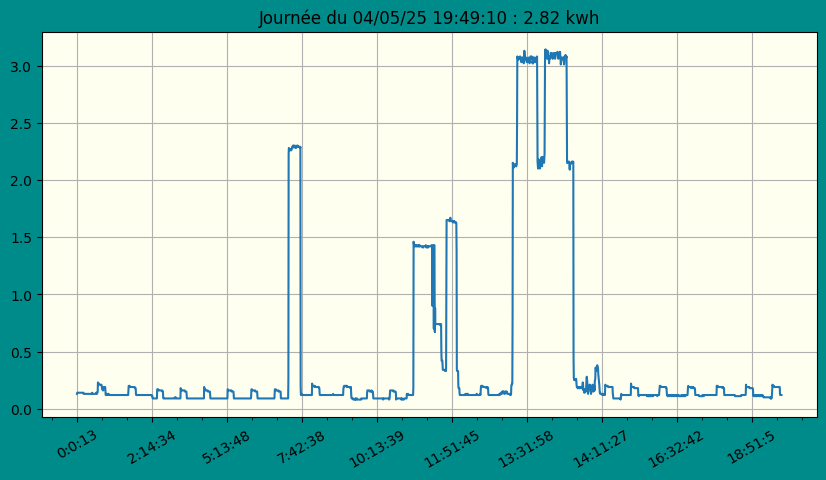

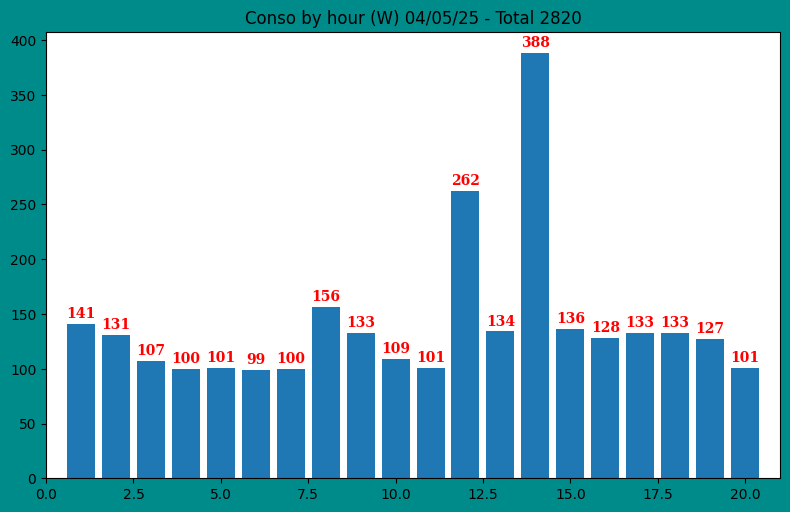

In [2218]:
show(today,bgcolor='ivory')
conso_by_hour(today)

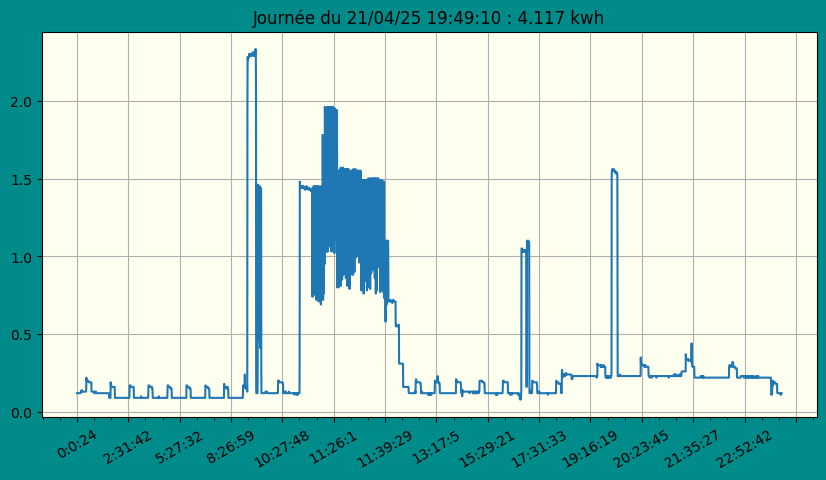

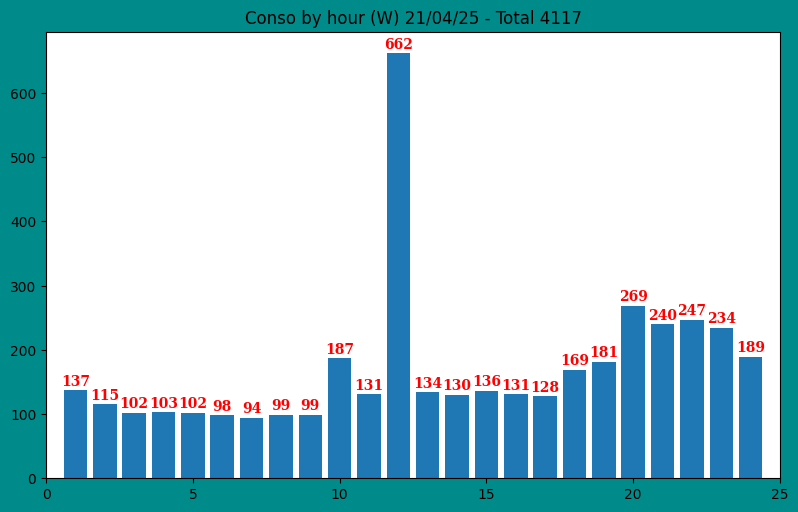

In [2219]:
day = '21/04/25' # 21/04/25 cuisine midi et télé le soir 4.115 kWh
day, show(day,bgcolor='ivory')
conso_by_hour(day)

22/01/25


(None, 4804)

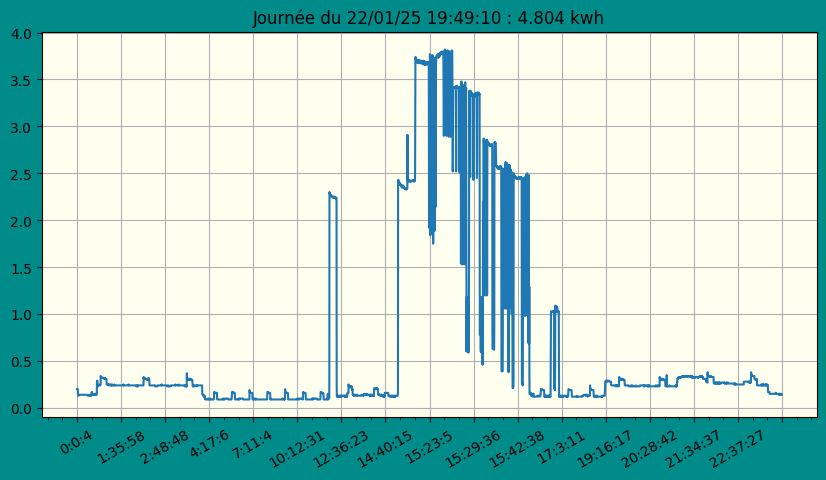

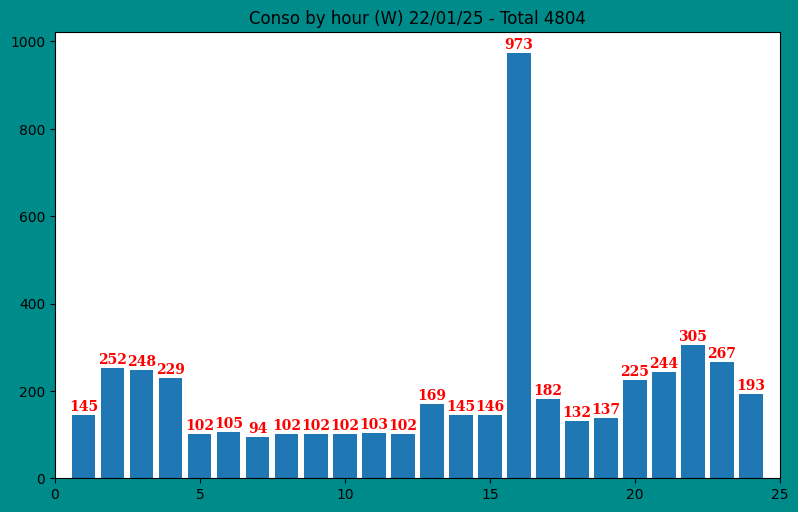

In [2220]:
print(maxday)
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')
conso_by_hour(day),sum(data)

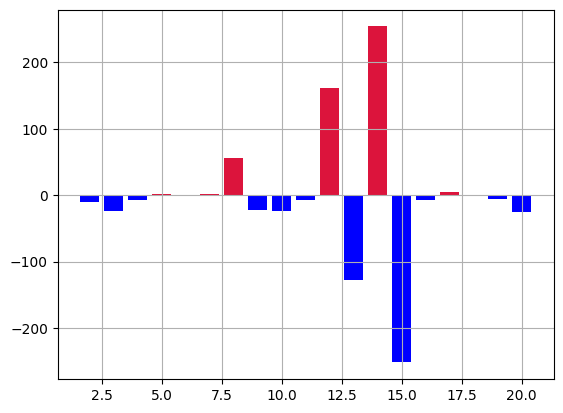

In [2221]:
diff = grp_by_dayhours.loc[today]
diff

x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

<Axes: xlabel='hours'>

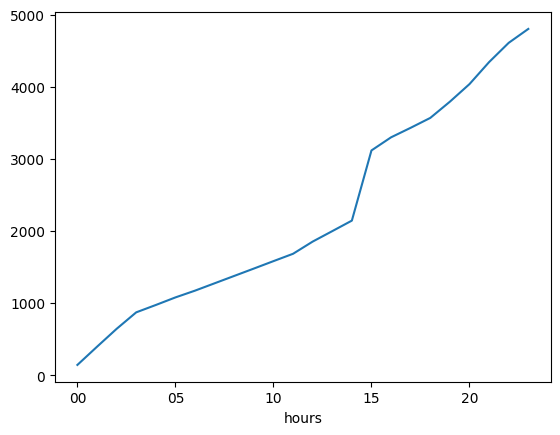

In [2222]:
data.cumsum().plot()


<Axes: xlabel='hours'>

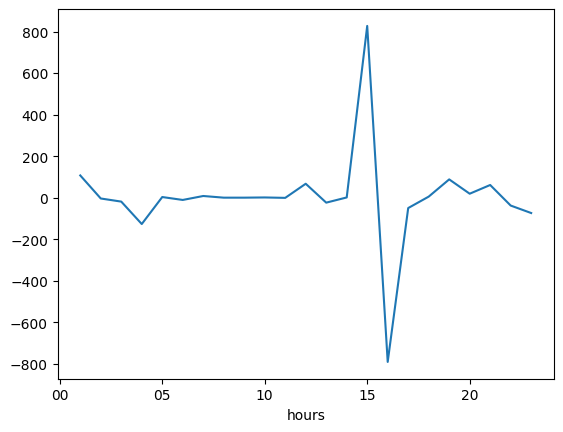

In [2223]:
# evolution par heure
data.diff().plot()

In [2224]:
data.diff().describe()

count     23.000000
mean       2.086957
std      248.997794
min     -791.000000
25%      -21.500000
50%        0.000000
75%       13.500000
max      827.000000
Name: kWh, dtype: float64

<Axes: >

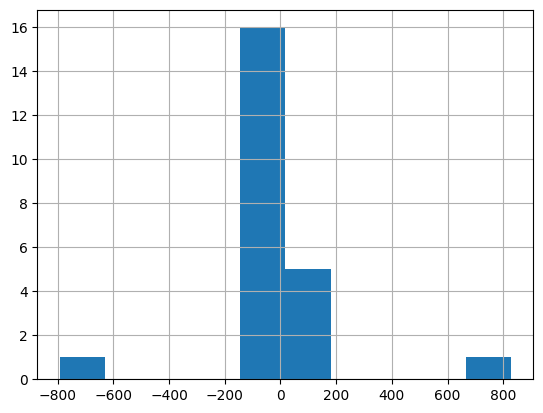

In [2225]:
data.diff().hist()

# Test sauvegarde

# list files in current directory


In [2226]:
import os
os.listdir(path='.')

['linear combination of atomic orbitals.ipynb',
 'loi_pareto.ipynb',
 'Lotka_Volterra_model.ipynb',
 'bitcoin_api.ipynb',
 'pencil_sketch.ipynb',
 'sample.json',
 'tricks.ipynb',
 'pandas_course2.ipynb',
 'socket_server.ipynb',
 'tree_minmax.ipynb',
 'amlich_data.py',
 'decimals_pi_plot.ipynb',
 'conso_jour.csv',
 'Mass_Spring_Damper.jpg',
 'mills_primes.ipynb',
 'ligue1_pandas.ipynb',
 'primes2million.pkl',
 'socket_client.ipynb',
 'magic_tricks.ipynb',
 'magicdragon.ipynb',
 'rainbow_color.ipynb',
 'snake_game.ipynb',
 'sympy_fun.ipynb',
 'tqdm_benchmark.ipynb',
 'ligue1_2020_extended.txt',
 'pd_grp_plot.ipynb',
 'tkinter_scale_color.ipynb',
 'Dewpoint-RH-fr.svg.png',
 'read_xml.ipynb',
 'pi_from_collisions.ipynb',
 'mqtt_temp.ipynb',
 'sudoku_generator.ipynb',
 'onecall_issue.ipynb',
 'poo_chap10.ipynb',
 'table-indicateurs-open-data-france-2023-06-30-17h59.csv',
 'primes12million.pkl',
 'espace_de_phase.ipynb',
 'ipinfo_test.ipynb',
 'enigma_settings.json',
 '__pycache__',
 'test_c

# list store files csv


In [2227]:
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

conso_jour.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
CAC40.csv
Nasdaq.csv
karaoke.csv
saturn_rings.csv
DowJones.csv
planete.csv
conso_par_jour.csv
8days.csv
SMSSpamCollection.csv
df_grp.csv
Ford.csv
Tesla.csv
Nikkei.csv
temp_humidity.csv
titanic.csv
data_temp16122022.csv
week.csv
Toyota.csv
Apple.csv
VNDUSD.csv
demain.csv
saturn_bodies.csv
conso_day_from_20230821.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
ligue1_2020_27.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
conso_data.csv
EURUSD.csv
df.csv


('22/01/25', None)

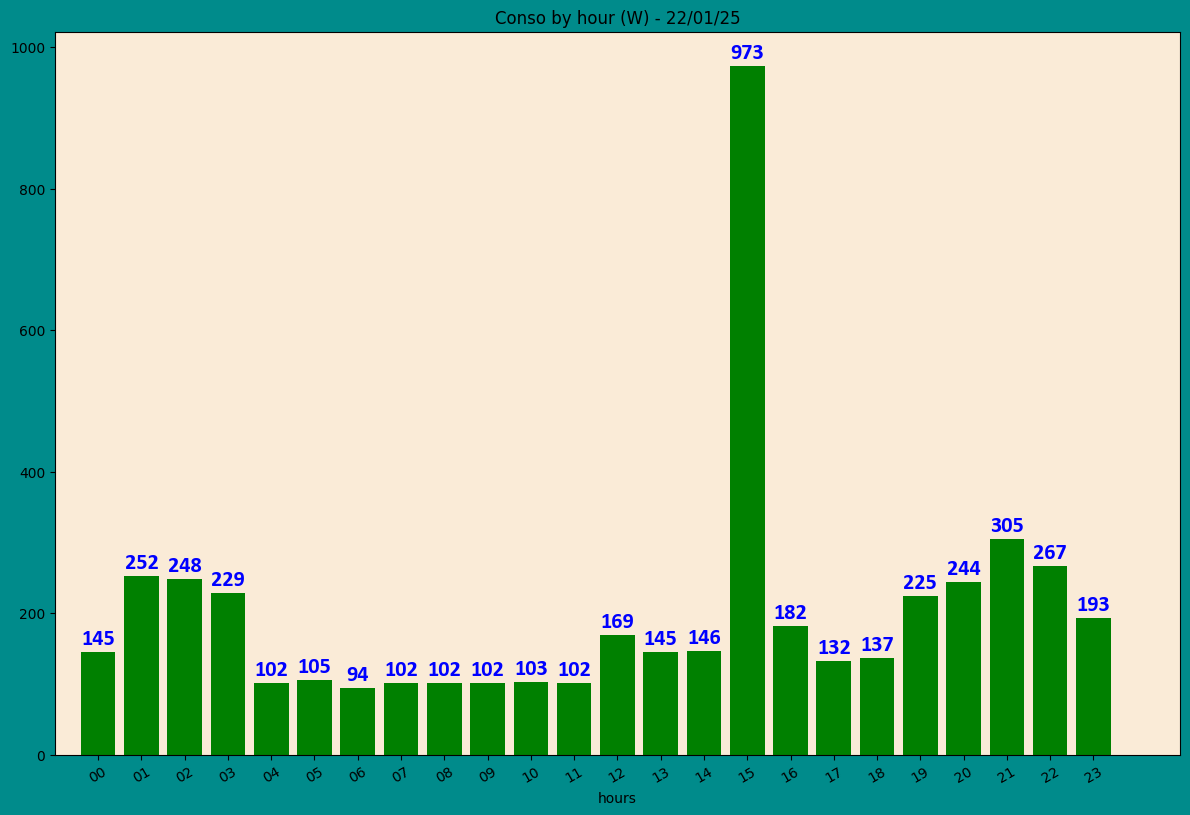

In [2228]:
day,conso_byhour(day)

In [2229]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


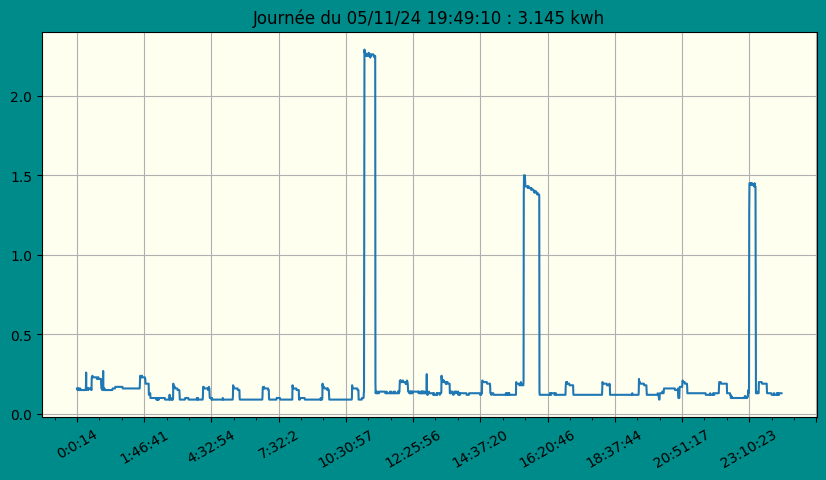

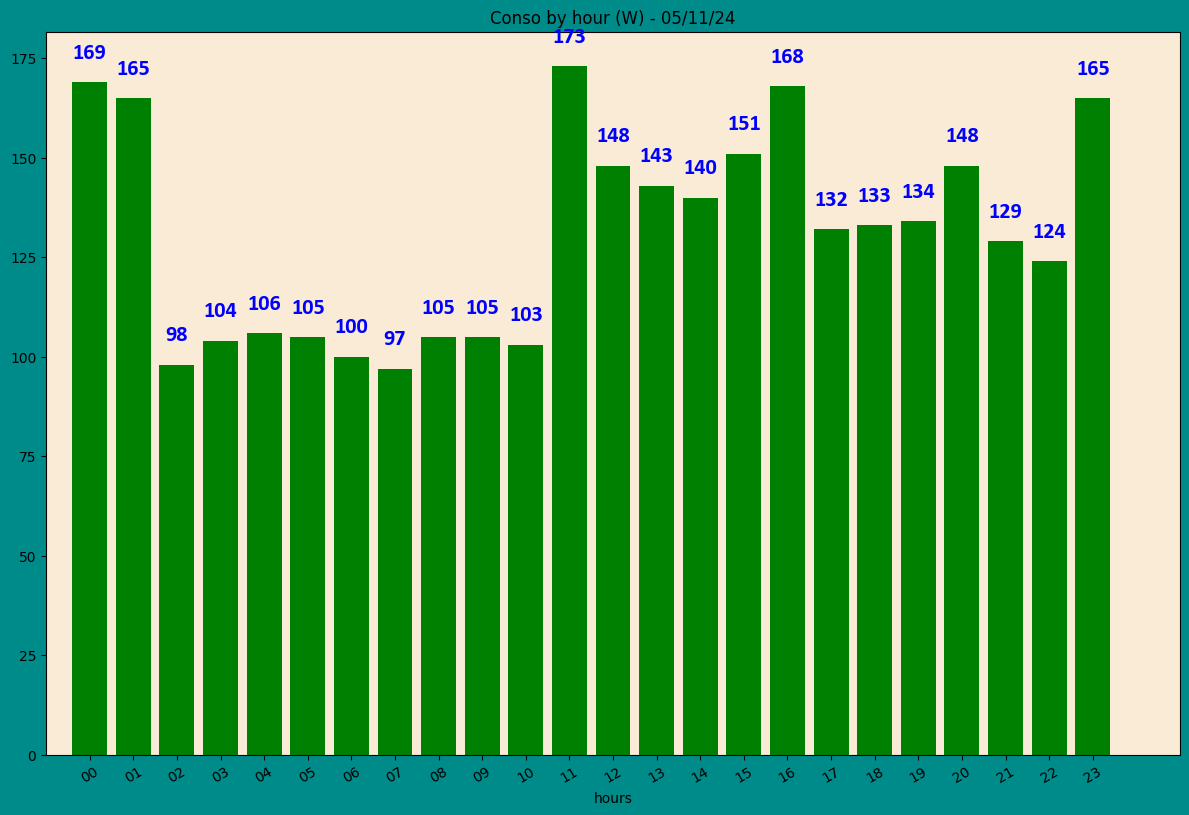

In [2230]:
day = '05/11/24'
#day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [2231]:
month

,day,hours,months,kWh
891517,01,00,2025-04,0.21
891518,01,00,2025-04,0.21
891519,01,00,2025-04,0.21
891520,01,00,2025-04,0.21
891521,01,00,2025-04,0.21
...,...,...,...,...
987267,30,23,2025-04,0.15
987268,30,23,2025-04,0.15
987269,30,23,2025-04,0.12
987270,30,23,2025-04,0.09


In [2232]:
month.describe()


,kWh
count,95755.000000
mean,0.310162
std,0.548122
min,0.080000
25%,0.090000
50%,0.120000
75%,0.180000
max,3.790000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

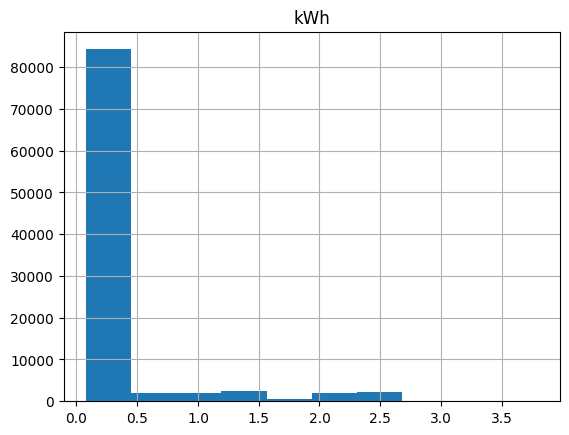

In [2233]:
month.hist()

<Axes: >

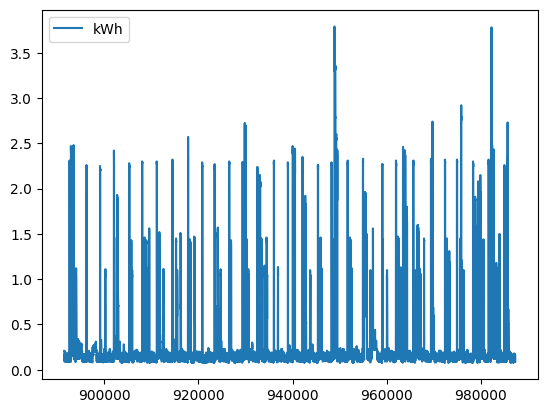

In [2234]:
month.plot()

In [2235]:
# index with max conso in this month
month.idxmax().kWh

np.int64(948896)

In [2236]:
# plot month day max conso (télévision de 11h à 23h)
day_idx = month.idxmax()
#day = '27/10/2024'
day_idx

day       984400
hours     894997
months    891517
kWh       948896
dtype: int64

In [2237]:
#show(day,pltcolor='darkcyan')
#conso_byhour(day)

In [2238]:
grp_by_dayhours

kWh  cumsum  diff  days
days     hours                         
09/07/24 11      29      29   NaN   NaN
         12     113     142  84.0   NaN
         13     114     256   1.0   NaN
         14     170     426  56.0   NaN
         15     155     581 -15.0   NaN
...             ...     ...   ...   ...
04/05/25 15     128    2326  -8.0  16.0
         16     133    2459   5.0  17.0
         17     133    2592   0.0  18.0
         18     127    2719  -6.0  19.0
         19     101    2820 -26.0  20.0

[7185 rows x 4 columns]

In [2239]:
month

,day,hours,months,kWh
891517,01,00,2025-04,0.21
891518,01,00,2025-04,0.21
891519,01,00,2025-04,0.21
891520,01,00,2025-04,0.21
891521,01,00,2025-04,0.21
...,...,...,...,...
987267,30,23,2025-04,0.15
987268,30,23,2025-04,0.15
987269,30,23,2025-04,0.12
987270,30,23,2025-04,0.09


In [2240]:
month.idxmax()


day       984400
hours     894997
months    891517
kWh       948896
dtype: int64

In [2241]:
month.loc[month.idxmax().kWh]


day            19
hours          12
months    2025-04
kWh          3.79
Name: 948896, dtype: object

In [2242]:
grp_by_dayhours.loc[['28/02/25']].kWh

days      hours
28/02/25  00       164
          01       120
          02       104
          03       110
          04       110
          05       107
          06       103
          07       110
          08       110
          09       103
          10       170
          11       146
          12       148
          13       141
          14       193
          15       144
          16       183
          17       170
          18       152
          19       144
          20       151
          21       170
          22       219
          23       171
Name: kWh, dtype: int64

In [2243]:
max_hour = grp_by_dayhours.loc[['28/02/25']].kWh.idxmax()[1]
max_hour

'22'

<Axes: xlabel='days,hours'>

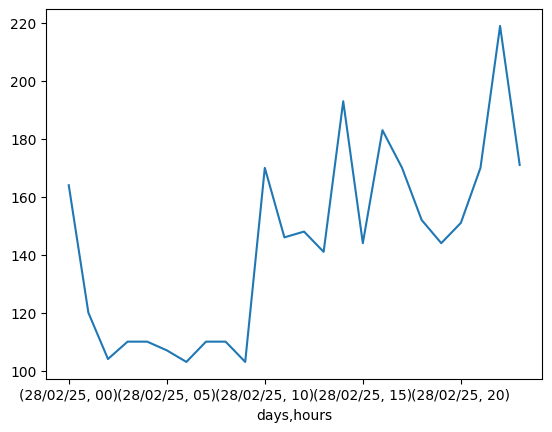

In [2244]:
grp_by_dayhours.loc[['28/02/25']].kWh.plot()#.idxmax()

In [2245]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

In [2246]:
# diff
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
# plt.legend()

In [2247]:
# cumsum
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
# plt.legend()

In [2248]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB